# 1- Importing Required Modules & Root Path

1) Required modules

In [1]:
import tensorflow as tf
import keras.layers as tfl
import PIL
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

In [2]:
path_root = "C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/"

2) GPU settings

In [3]:
# gpus = tf.config.list_physical_devices("GPU")
# try:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
# except Exception as e:
#     print(e)

# 2- Importing Dataset

## 2.1- Getting Filenames Dataset

1) Defining dataset path

In [4]:
path_dataset = path_root + "datasets/MLRSNet/Images"

2) Creating list dataset that contains file names with full path by using dataset root path

In [5]:
list_dataset = tf.data.Dataset.list_files(str(path_dataset+"/*/*"), shuffle=True)

# Examples
for ex in list_dataset.take(5):

    # Print modified-for-readiblity version of samples 
    print(ex.numpy().split(b"/")[-4:])

[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\river\\river_00138.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\snowberg\\snowberg_01513.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\river\\river_01567.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\mobile_home_park\\mobile_home_park_00480.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\meadow\\meadow_03229.jpg']


## 2.2- Getting Image Dataset

1) Mapping "path to image" operation in order to get image dataset 

In [3]:
def convert_path_to_image(name_path):

    # Path-to-image conversion and image decoding
    path_parts = tf.strings.split(name_path, os.sep)
    # Get label from root file of image 
    label = path_parts[-2]
    # Read image from given path
    image = tf.io.read_file(name_path)
    # Decode image as JPEG
    image = tf.io.decode_jpeg(image, channels=3)

    # Return image and label
    return image, label

2) Applying mapping to dataset

In [7]:
image_dataset = list_dataset.map(convert_path_to_image)
print(image_dataset.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


3. Testing mapping by sampling image dataset

In [8]:
def mapping_test(dataset, num=3, one_hot_label=False, classes=None):

    # Defining the subplot
    fig, axes = plt.subplots(1,num, figsize=(12,6))
    
    for i, (image,label) in enumerate(dataset.take(num)):
        # Showing the  sample image 
        axes[i].imshow(image)
        # one_hot_label condition
        if not one_hot_label:
            # If the label is not one-hot-encoded
            label = label.numpy().decode("utf-8")
        else:
            # If the label is one-hot-encoded
            print("One-Hot label:", label)
            label_ind = tf.argmax(label).numpy()
            label = classes[label_ind] 
        # Showing the label as title
        axes[i].set_title(label)
        
    # Showing the plot 
    plt.show()

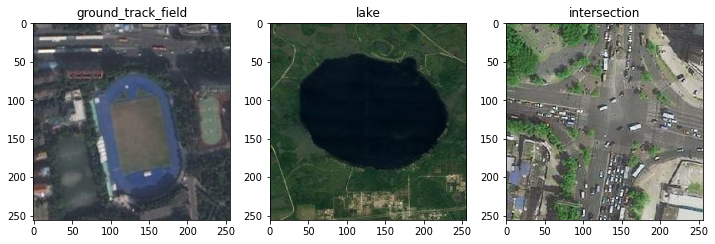

In [9]:
mapping_test(image_dataset)

## 2.3- Preprocessing Image Dataset

### 2.3.1- Applying "One-Hot Encoding"

1) Loading class names as a list from "class_names.csv" file

In [10]:
classes_list = []
path_classes_list_file = path_root + "datasets/MLRSNet/class_names.csv"

with open(path_classes_list_file, "r", ) as my_file:
    new_content = csv.reader(my_file)
    for row in new_content:
        classes_list.append(row[0])

In [11]:
print(classes_list)
print("number of classes:", len(classes_list))

['airplane', 'airport', 'bareland', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland', 'farmland', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor&port', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway', 'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard', 'snowberg', 'sparse_residential_area', 'stadium', 'storage_tank', 'swimmimg_pool', 'tennis_court', 'terrace', 'transmission_tower', 'vegetable_greenhouse', 'wetland', 'wind_turbine']
number of classes: 46


2) Defining one_hot_encoder function which takes "image" and "label" of each element and, outputs "image" "one hot encoded label"

In [12]:
def one_hot_encoder(image, label, classes):

    # Get the boolean match of the label
    tensor_classes_bool = tf.constant(classes) == label
    # Cast the boolean result as a tf.float32 tensor
    label_one_hot = tf.cast(tensor_classes_bool, dtype=tf.float32)

    # Return to replace
    return (image, label_one_hot)

3) Applying the transformation

In [13]:
image_dataset = image_dataset.map(lambda image,label: one_hot_encoder(image, label, classes_list))

In [14]:
print(image_dataset.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))


### 2.3.2- Resizing Image Dataset

1) Defining dataset element resizer function

In [15]:
def resize_image(image, label, size=[227,227]):

    # Resizing
    image = tf.image.resize(image, size)
    # Type casting to uint8 from float32
    image = tf.cast(image, dtype=tf.uint8) 
    # Normalization
    # image = tf.image.convert_image_dtype(image, tf.float32) 

    # Return image and label
    return image, label

2) Mapping the resizer function to the dataset

In [16]:
image_dataset = image_dataset.map(lambda image,label: resize_image(image,label, [227,227]))

In [17]:
print(image_dataset.element_spec)

(TensorSpec(shape=(227, 227, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))


3) Mapping test to the resized dataset

One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)


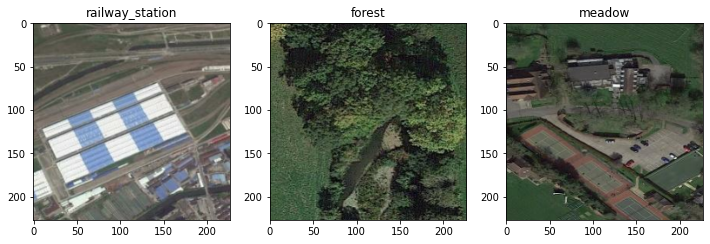

In [18]:
mapping_test(image_dataset, one_hot_label=True, classes=classes_list)

### 2.3.3- Scaling Image Dataset

1) Definign rescaler function that rescales each image element to between 0-1

In [19]:
def rescaler(image,label):

    # Apply scaling (normalization from statistic convension) to range between 0-1 
    image = tfl.Rescaling(scale=1./255) (image)

    # Return image and label
    return image,label

2) Apply the transformation

In [20]:
image_dataset = image_dataset.map(rescaler)

3) Test the mapping

tf.Tensor(
[[[0.44705886 0.40000004 0.3372549 ]
  [0.36078432 0.3137255  0.2509804 ]
  [0.3372549  0.2901961  0.227451  ]
  ...
  [0.5019608  0.47450984 0.40000004]
  [0.5058824  0.4784314  0.40784317]
  [0.38823533 0.36078432 0.2901961 ]]

 [[0.47058827 0.42352945 0.36078432]
  [0.3372549  0.2901961  0.227451  ]
  [0.34509805 0.29803923 0.23529413]
  ...
  [0.5137255  0.4901961  0.41176474]
  [0.5803922  0.5529412  0.47450984]
  [0.59607846 0.5686275  0.49411768]]

 [[0.6039216  0.5568628  0.49411768]
  [0.5686275  0.52156866 0.45882356]
  [0.5411765  0.49411768 0.43137258]
  ...
  [0.5921569  0.5686275  0.48235297]
  [0.48235297 0.45882356 0.37254903]
  [0.4666667  0.4431373  0.35686275]]

 ...

 [[0.27058825 0.34901962 0.2392157 ]
  [0.27058825 0.34901962 0.2392157 ]
  [0.27058825 0.34901962 0.2392157 ]
  ...
  [0.25882354 0.34901962 0.23529413]
  [0.25882354 0.34901962 0.23529413]
  [0.26666668 0.35686275 0.24313727]]

 [[0.27058825 0.34901962 0.2392157 ]
  [0.27058825 0.34901962 0

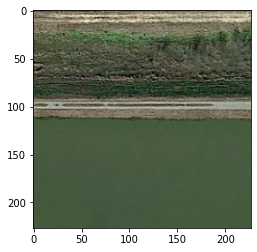

In [21]:
for image,label in image_dataset.take(1):
    print(image)
    print(label.numpy())
    img_ind = np.argmax(label.numpy())
    print(classes_list[img_ind])
    plt.imshow(image)

## 2.4- Configuring Image Dataset

1) Splitting training and test sets

In [22]:
def split_dataset(dataset, train_set_ratio, test_set_ratio, val_set_ratio=0):
    
    # Get the dataset length
    len_dataset = len(image_dataset)

    # Check if the ratio is correct
    if train_set_ratio + val_set_ratio + test_set_ratio != 1:
        raise ValueError("Incorrect split ratio")

    # Calculate the indices
    train_size = int(len_dataset * train_set_ratio)
    remaining_size = int(len_dataset - train_size)

    # If the val_set is intended
    if val_set_ratio != 0:
        val_set_ratio_remaining = float(val_set_ratio / (val_set_ratio + test_set_ratio))
        #print("val_set_ratio_remaining", val_set_ratio_remaining)
        val_size = int(remaining_size *  val_set_ratio_remaining)
        val_index = train_size + val_size
        test_size = remaining_size - val_size

    else:
        test_size = remaining_size

    # Write the sizes
    print("train size:",train_size)
    print("test size:", test_size)
    if val_set_ratio != 0: 
        print("val size:", val_size)

    # Split the dataset
    dataset_train = dataset.take(train_size)
    dataset_remaining = dataset.skip(train_size)

    if val_set_ratio != 0:
        dataset_val = dataset_remaining.take(val_size)
        dataset_test = dataset_remaining.skip(val_size)
         
        return dataset_train, dataset_test, dataset_val
        
    else:
        dataset_test = dataset_remaining
        return dataset_train, dataset_remaining


In [23]:
dataset_train, dataset_test, dataset_val = split_dataset(image_dataset, 0.8, 0.1, 0.10)

train size: 87328
test size: 10917
val size: 10916


2) Configuring mini batches

In [24]:
dataset_train = dataset_train.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(8, drop_remainder=True)
dataset_val = dataset_val.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(8, drop_remainder=True)
dataset_test = dataset_test.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(8, drop_remainder=True)

# 3- Building Model

1) Defining the model architecture

In [25]:
def VGG16(input_shape=(227,227,3), num_output_classes=10):

    """
    VGG-16 (Configuration-D) implementation with the architecture from the original paper by Simonyan et al. (2014)
    
    inputs:
        input_shape - input shape for input image size from the original paper
        num_output_classes - output unit size for softmax classifier that decided by model purpose

    outputs:
        model - VGG-16 model Keras instance 
    """

    # input layer: tensor-like input object
    layer_input = tf.keras.Input(input_shape)

    # layer-1: [1-2/16] 2x64 2D convolution (filters:128, kernel:3x3, stride:1x1), MaxPooling (pool:2x2, stride:2x2)
    layer1 = tfl.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer_input)
    layer1 = tfl.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer1)
    layer1 = tfl.MaxPool2D(pool_size=(2,2), strides=(2,2)) (layer1)

    # layer-2: [3-4/16] 2x 2D convolution (filters:128, kernel:3x3, stride:1x1), MaxPooling (pool:2x2, stride:2x2)
    layer2 = tfl.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer1)
    layer2 = tfl.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer2)
    layer2 = tfl.MaxPool2D(pool_size=(2,2), strides=(2,2)) (layer2)

    # layer-3: [5-6-7/16] 3x 2D convolution (filters:256, kernel:3x3, stride:1x1), MaxPooling (pool:2x2, stride:2x2)
    layer3 = tfl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer2)
    layer3 = tfl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer3)
    layer3 = tfl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer3)
    layer3 = tfl.MaxPool2D(pool_size=(2,2), strides=(2,2)) (layer3)

    # layer-4: [8-9-10/16] 3x 2D convolution (filters:256, kernel:3x3, stride:1x1), MaxPooling (pool:2x2, stride:2x2)
    layer4 = tfl.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer3)
    layer4 = tfl.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer4)
    layer4 = tfl.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer4)
    layer4 = tfl.MaxPool2D(pool_size=(2,2), strides=(2,2)) (layer4)

    # layer-5: [11-12-13/16] 3x 2D convolution (filters:256, kernel:3x3, stride:1x1), MaxPooling (pool:2x2, stride:2x2)
    layer5 = tfl.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer4)
    layer5 = tfl.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer5)
    layer5 = tfl.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same") (layer5)
    layer5 = tfl.MaxPool2D(pool_size=(2,2), strides=(2,2)) (layer5)
    layer5 = tfl.Flatten() (layer5)

    # layer-6: [14/16] fully-connected layer (units:4096, activation:relu)
    layer6 = tfl.Dense(units=4096, activation="relu") (layer5)
    layer6 = tfl.Dropout(rate=0.5) (layer6)

    # layer-7: [15/16] fully-connected layer (units:4096, activation:relu)
    layer7 = tfl.Dense(units=4096, activation="relu") (layer6)
    layer7 = tfl.Dropout(rate=0.5) (layer7)

    # layer-8 (output layer): [16/16] fully-connected (units:num. of classes, activation:softmax)
    layer_output = tfl.Dense(units=num_output_classes, activation="softmax") (layer7)

    # Defining Model object
    model = tf.keras.Model(inputs= layer_input,
                            outputs=layer_output,
                            )

    # Returning the model
    return model
    

2) Creating a CNN model

Defining input shape

In [26]:
input_shape = tuple([int(i) for i in image_dataset.element_spec[0].shape.__repr__()[-13:-2].split(", ")])
print("Input shape:",input_shape)

Input shape: (227, 227, 3)


Defining output shape

In [27]:
output_classes_shape = len(classes_list)
print("Output shape:", output_classes_shape)

Output shape: 46


In [28]:
VGG16Model = VGG16(input_shape, output_classes_shape)

3) Compiling the model

In [29]:
VGG16Model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                    loss= tf.keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"])

In [30]:
VGG16Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 227, 227, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 113, 113, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 113, 113, 128)     147584    
                                                             

# 4- Training Model

1) Defining training callbacks

In [31]:
# Define the checkpoint path
path_checkpoint = path_root + "checkpoints/vgg16_model_{epoch:02d}-{val_accuracy:.2f}"

# Define the ModelCheckpoint callback
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,
    save_weights_only=False,
    monitor="val_accuracy",
    save_freq="epoch" )

# Define the EarlyStopping callback
callback_early_stopping  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

2) Fitting (training) the model

In [32]:
history = VGG16Model.fit(
    x=dataset_train,
    epochs=30,
    validation_data=dataset_val,
    callbacks=[
        callback_model_checkpoint,
        callback_early_stopping
        ])

Epoch 1/30
10916/10916 [==============================] - 3357s 307ms/step - loss: 3.7660 - accuracy: 0.0336 - val_loss: 3.3900 - val_accuracy: 0.1043
Epoch 2/30
10916/10916 [==============================] - 3364s 308ms/step - loss: 2.7134 - accuracy: 0.2551 - val_loss: 1.8245 - val_accuracy: 0.4813
Epoch 3/30
10916/10916 [==============================] - 3363s 308ms/step - loss: 1.5566 - accuracy: 0.5555 - val_loss: 0.9760 - val_accuracy: 0.7171
Epoch 4/30
10916/10916 [==============================] - 3379s 309ms/step - loss: 1.0206 - accuracy: 0.7005 - val_loss: 0.6925 - val_accuracy: 0.7923
Epoch 5/30
10916/10916 [==============================] - 4577s 419ms/step - loss: 0.7518 - accuracy: 0.7774 - val_loss: 0.5099 - val_accuracy: 0.8446
Epoch 6/30
10916/10916 [==============================] - 3364s 308ms/step - loss: 0.5774 - accuracy: 0.8262 - val_loss: 0.4153 - val_accuracy: 0.8777
Epoch 7/30
10916/10916 [==============================] - 3363s 308ms/step - loss: 0.4607 - ac

3. Plotting accuracy & loss graphs

In [ ]:
history_loss = history.history["loss"]
history_accuracy = history.history["accuracy"]
history_val_loss = history.history["val_loss"]
history_val_accuracy = history.history["val_accuracy"]

In [ ]:
fig1, (ax11, ax12)  = plt.subplots(1, 2, figsize=(16,8))
ax11.plot(history_loss, label="train")
ax11.plot(history_val_loss, label="validation")
ax11.set_title("model loss")
ax11.legend(loc="upper right")
ax11.grid()

ax12.plot(history_accuracy, label="train")
ax12.plot(history_val_accuracy, label="validation")
ax12.set_title("model accuracy")
ax12.legend(loc="upper right")
ax12.grid()

# 5- Testing (Evaluating) the Model

In [27]:
test_history = VGG16Model.evaluate(dataset_test)

1364/1364 [==============================] - 207s 108ms/step - loss: 0.0514 - accuracy: 0.9852


In [ ]:
print("Test loss:", test_history[0])
print("Test accuracy:", test_history[1])

# 6- Saving Model

In [23]:
model_name = "MLRSNet_VGG16_14"

model_path = path_root + "models/" + model_name
print(model_path)

C:/Users/Deniz/CODEWORKS/last_remote_sensing/models/MLRSNet_VGG16_14


In [ ]:
#VGG16Model.save(model_path)

# 7- Reload Saved Model

In [4]:
model_name = "MLRSNet_VGG16_14"

model_path = path_root + "models/" + model_name
print(model_path)

C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/models/MLRSNet_VGG16_14


In [5]:
model_reloaded = tf.keras.models.load_model(model_path)

# 8- Make Predictions

## 8.1- User Image Prediction 

Load an user image to evaluate its content by using the trained model
1) Definition of untility functions

In [6]:
def load_user_image(path):

    # Lazy-load the image with PIL
    image_user = PIL.Image.open(path)
    plt.imshow(image_user)
    # Resize the image
    image_user = tf.image.resize(image_user, [227,227])
    # Rescale the image
    image_user = tfl.Rescaling(scale=1./255) (image_user)
    # Add batch axis
    image_user = image_user[tf.newaxis,:]
    print("User Image Shape:", image_user.shape)

    # Return the image
    return image_user

In [7]:
def print_pred_result(result, classes):
    print(f"{'Predictions':<30}Confidences")
    result_top5 = []
    result = list(result[0])

    zipped_results = list(zip(result, list(enumerate(classes))))
    sorted_zipped_results = sorted(zipped_results, reverse=True)
    sorted_results_top5 = sorted_zipped_results[:5]
    
    for i, result in enumerate(sorted_results_top5):

        result_index = result[1][0]
        predicted_class = result[1][1]
        confidence = result[0]
        print(f"{i+1} - {predicted_class:<25} - {confidence*100:.5f} %")
        result_top5.append([result_index, predicted_class, confidence])

    # return top-5 prediction list
    return result_top5

2) Define the user image path 

In [20]:
path_user_image = path_root + "user_images/bridge/bridge_4.png"

3) Load the user image and preprocess within the 'load_user_image' function

User Image Shape: (1, 227, 227, 3)


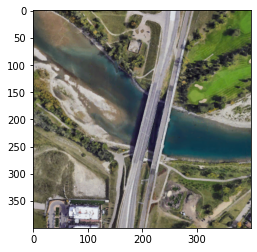

In [21]:
image_user = load_user_image(path_user_image)

4) Make prediction by using the trained model

In [22]:
result_user_image = model_reloaded.predict(image_user)

5) Print the top-5 prediction result

In [23]:
result_top5 = print_pred_result(result_user_image, classes_list)

Predictions                   Confidences
1 - bridge                    - 90.08823 %
2 - overpass                  - 9.40688 %
3 - roundabout                - 0.30444 %
4 - intersection              - 0.19469 %
5 - airport                   - 0.00493 %


## 8.2- User Set Prediction

1. Define the user image path

In [11]:
path_user_set = path_root + "user_images"
path_user_set

'C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/user_images'

2. Get the user dataset with filenames format

In [12]:
list_user_set = tf.data.Dataset.list_files(str(path_user_set+"/*/*"), shuffle=True)

# Examples
for ex in list_user_set.take(5):
    # Print modified-for-readiblity version of samples 
    print(ex.numpy().split(b"/")[-4:])

[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\intersection\\intersection_0.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\island\\island_1.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\mountain\\mountain_3.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\intersection\\intersection_2.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\airport\\airport_4.png']


3) Apply "convert_path_to_image"

In [13]:
image_user_set = list_user_set.map(convert_path_to_image)

4) Apply "one_hot_encoder"

In [14]:
image_user_set = image_user_set.map(lambda image,label: one_hot_encoder(image, label, classes_list))

5) Apply "resize_image"

In [15]:
def resize_image(image, label, size=[227,227]):
    # Resizing
    image = tf.image.resize(image, size)
    # Type casting to uint8 from float32
    image = tf.cast(image, dtype=tf.uint8) 

    # Return image and label
    return image, label

In [16]:
image_user_set = image_user_set.map(resize_image)

6) Apply "rescaler"

In [17]:
image_user_set = image_user_set.map(rescaler)

Mapping Test

One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)


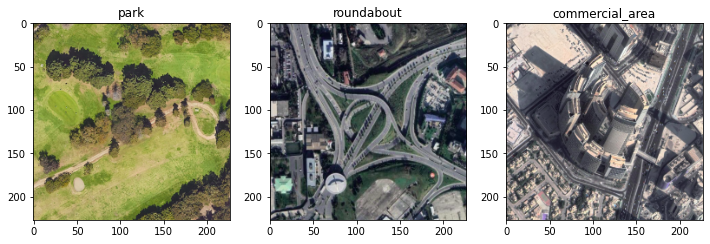

In [18]:
mapping_test(image_user_set, one_hot_label=True, classes=classes_list)

7. Apply mini-batching

In [19]:
image_user_set = image_user_set.batch(8)

In [20]:
image_user_set.element_spec

(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 46), dtype=tf.float32, name=None))

8) Predict user set

In [21]:
results_user_set = model_reloaded.evaluate(image_user_set)

20/20 [==============================] - 9s 141ms/step - loss: 3.4125 - accuracy: 0.5128


User Set Top-1 Score:

In [22]:
print("User set loss:", results_user_set[0])
print("User set accuracy:", results_user_set[1])

User set loss: 3.4125208854675293
User set accuracy: 0.5128205418586731
